In [1]:
import cv2
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
from PIL import Image 
from glob import glob
from pathlib import Path
import imageio.v2 as imageio
from datetime import datetime
from typing import Union, List, Optional, Tuple

sys.path.append(str(Path().absolute().parent))
import plotting
import importlib
importlib.reload(plotting)
# from plotting import overlay_masks_on_data

<module 'plotting' from '/home/sangohe/projects/pathology/plotting.py'>

# Resources
- [5 Ways to Make Histopathology Image Models More Robust to Domain Shifts](https://towardsdatascience.com/5-ways-to-make-histopathology-image-models-more-robust-to-domain-shifts-323d4d21d889)

# Questions
- Is the transparency/alpha information (RGBA vs RGB) relevant to solve the problem?
- The images were captured with different scanners, inducing image variations?
- How patches were sampled? There's some overlapping between them?
- How to reconstruct the patches?
- How to overlap the reconstructed image (from patches) with the mask?

# Helpers

In [2]:
bins = np.linspace(0, 255, 52)


def exists(obj):
    return obj is not None


def print_img_info(img: np.ndarray, desc: str = ""):
    print(
        desc,
        f"min: {img.min()}",
        f"max: {img.max() }",
        f"mean: {img.mean():.2f}",
        f"ndim: {img.ndim}",
        f"channels: {img.shape[-1]}",
    )


def read_image(image_path: Union[str, Path]) -> np.ndarray:
    """Reads an image from a path and converts it to RGB format."""
    if isinstance(image_path, Path):
        image_path = str(image_path)
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    return image.astype(np.float32)


def read_mask(mask_path: Union[str, Path]) -> np.ndarray:
    """Reads a mask from a path and transform it to binary."""
    if isinstance(mask_path, Path):
        mask_path = str(mask_path)
    mask = cv2.imread(mask_path, 0) / 255.0
    assert_mask_is_binary(mask)
    return mask.astype(np.float32)


def assert_mask_is_binary(mask: np.ndarray):
    """Counts all the pixels different to zero and one to check if binary."""
    assert (
        np.count_nonzero((mask != 0) & (mask != 1)) == 0
    ), f"Mask is not binary. Unique values: {np.unique(mask)}"


def read_images_grid(
    patches_paths: Union[List[str], List[Path]]
) -> List[List[np.ndarray]]:
    patches = []
    for i, patches_paths_row in enumerate(patches_paths):
        images_row = []
        for j, patch_path in enumerate(patches_paths_row):
            image = read_image(patch_path) if exists(patch_path) else np.zeros((1024, 1024, 3))
            images_row.append(image)
        patches.append(images_row)
    return patches


def crop_black_frames_from_image(img: np.ndarray) -> np.ndarray:    
    positions = np.nonzero(img)
    top = positions[0].min()
    bottom = positions[0].max()
    left = positions[1].min()
    right = positions[1].max()
    return img[top:bottom, left:right]


def sort_paths_from_idxs(
    patches_paths: Union[List[str], List[Path]]
) -> List[List[Union[str, Path]]]:
    """Creates a grid of paths from a list of paths based on their ids."""
    if isinstance(patches_paths[0], str):
        patches_paths = [Path(patch_path) for patch_path in patches_paths]
    idxs = [patch_path.stem.split("_")[-2:] for patch_path in patches_paths]
    idxs = [[int(i[0]), int(i[1])] for i in idxs]

    # Create the grid.
    (y_min, x_min), (y_max, x_max) = np.min(idxs, axis=0), np.max(idxs, axis=0)
    sorted_paths, missing_patches_idxs = [], []
    for j in range(y_max + 1):
        row_paths = []
        for i in range(x_max + 1):
            if [j, i] not in idxs:
                missing_patches_idxs.append([j, i])
                row_paths.append(None)
            else:
                row_paths.append(patches_paths[idxs.index([j, i])])
        sorted_paths.append(row_paths)

    return sorted_paths, missing_patches_idxs


# Exploration

Create variables pointing to the directories holding the histopathological data

In [3]:
dset_dir = "/data/histopathology/TCGA/"
dset_dir = Path(dset_dir)

patches_dir = dset_dir / "patches"
masks_dir = dset_dir / "masks"

# In the patches directory are more directories and in the masks directory are png files.
patches_dirs = sorted(patches_dir.iterdir())
masks_paths = sorted(masks_dir.iterdir())

## How to read histopathological images

The first thing to check is how are these images codified. Read them with different libraries.

In [4]:
# Convert to RGB for cv2 images.
first_patch_path = str(sorted(patches_dirs[0].iterdir())[0])
cv_img = cv2.cvtColor(cv2.imread(first_patch_path), cv2.COLOR_BGR2RGB)
cv_img_unchanged = cv2.cvtColor(cv2.imread(first_patch_path, -1), cv2.COLOR_BGRA2RGBA)
io_img = imageio.imread(first_patch_path)
pil_img = np.array(Image.open(first_patch_path))

print_img_info(cv_img, desc="Standard cv imread")
print_img_info(cv_img_unchanged, desc="Unchanged cv imread")
print_img_info(io_img, desc="Imageio imread")
print_img_info(pil_img, desc="PIL imread")

assert np.array_equal(cv_img_unchanged, io_img) and np.array_equal(
    cv_img_unchanged, pil_img
), "Images are not equal."


Standard cv imread min: 0 max: 255 mean: 191.24 ndim: 3 channels: 3
Unchanged cv imread min: 0 max: 255 mean: 207.18 ndim: 3 channels: 4
Imageio imread min: 0 max: 255 mean: 207.18 ndim: 3 channels: 4
PIL imread min: 0 max: 255 mean: 207.18 ndim: 3 channels: 4


Imageio, PIL and OpenCV (if specified) read the images without changing their intensity values. The images seem to be codified in RGB with transparency. <span style="color:red">*Is the transparency information relevant to solve the problem?*</span>

Plot the different images to check if there are noticeable differences.

Text(0.5, 1.0, 'PIL imread')

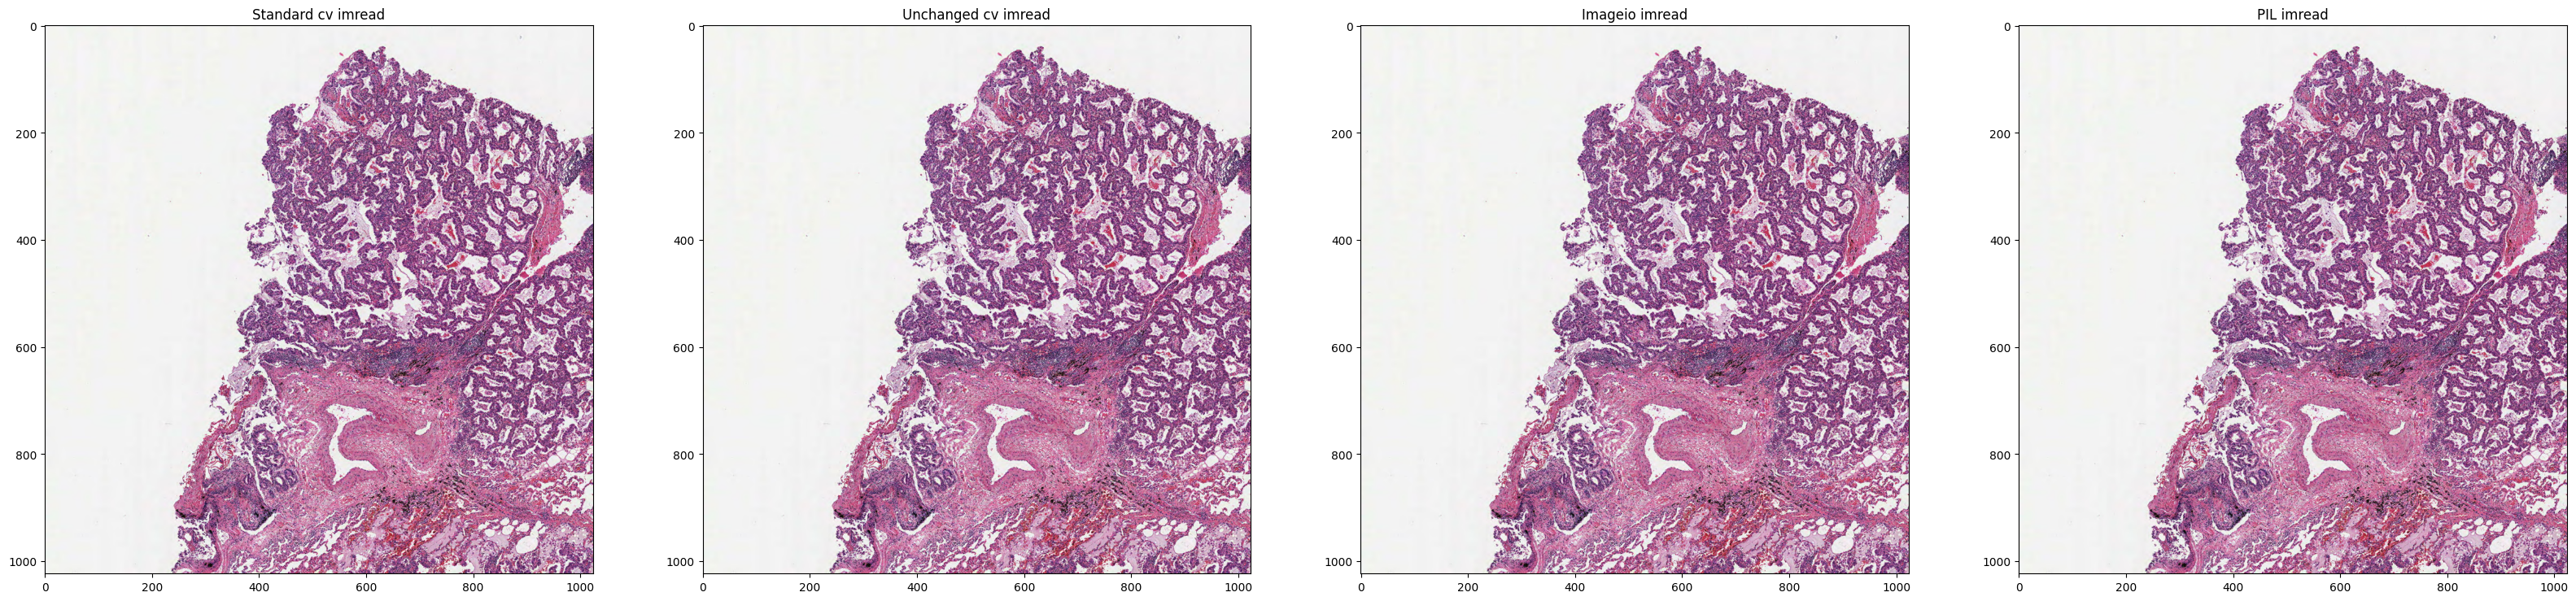

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(40, 10))
ax[0].imshow(cv_img)
ax[0].set_title("Standard cv imread")
ax[1].imshow(cv_img_unchanged)
ax[1].set_title("Unchanged cv imread")
ax[2].imshow(io_img)
ax[2].set_title("Imageio imread")
ax[3].imshow(pil_img)
ax[3].set_title("PIL imread")


There are no noticeable visual differences. Check the mean intensity for the last channel in the images with transparency

(array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
        110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
        165., 170., 175., 180., 185., 190., 195., 200., 205., 210., 215.,
        220., 225., 230., 235., 240., 245., 250., 255.]),
 <BarContainer object of 51 artists>)

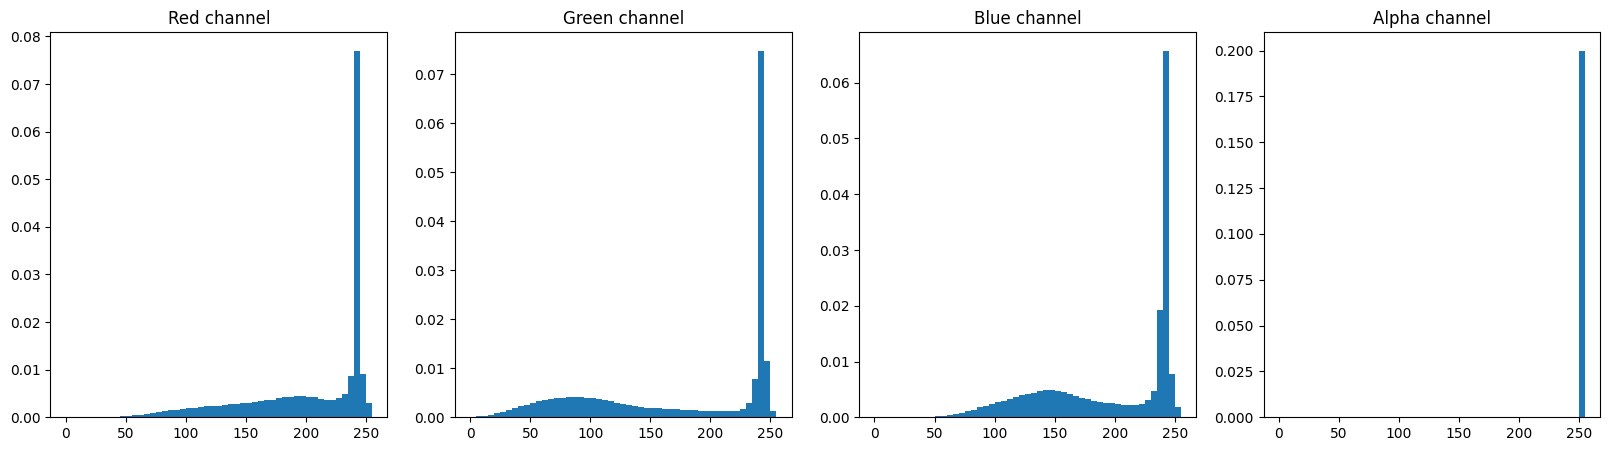

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].set_title("Red channel")
ax[0].hist(cv_img_unchanged[..., 0].ravel(), density=True, bins=bins)
ax[1].set_title("Green channel")
ax[1].hist(cv_img_unchanged[..., 1].ravel(), density=True, bins=bins)
ax[2].set_title("Blue channel")
ax[2].hist(cv_img_unchanged[..., 2].ravel(), density=True, bins=bins)
ax[3].set_title("Alpha channel")
ax[3].hist(cv_img_unchanged[..., 3].ravel(), density=True, bins=bins)


Might be a bit hasty, but judging by the intensity distribution in the transparency channel, you could use the images with their RGB coding and not RGBA. In fact, if we look at the minimum, maximum and average values we can corroborate that all the information is located in a very small interval.

In [8]:
print(
    "Alpha channel ->",
    "min:",
    cv_img_unchanged[..., 3].min(),
    "max:",
    cv_img_unchanged[..., 3].max(),
    "mean:",
    cv_img_unchanged[..., 3].mean(),
)


Alpha channel -> min: 254 max: 255 mean: 254.998046875


Take more samples and see if the same conclusions can be drawn

In [9]:
patches_paths = []
for patch_dir in patches_dirs:
    patches_paths.extend(sorted(patch_dir.iterdir()))


np.random.seed(4321)
random_patches_paths = np.random.choice(patches_paths, size=200, replace=False)

patches = []
for random_patch_path in random_patches_paths:
    patch = cv2.cvtColor(cv2.imread(str(random_patch_path), -1), cv2.COLOR_BGRA2RGBA)
    patches.append(patch)


patches = np.array(patches)
print_img_info(patches, desc="Patches")


Patches min: 0 max: 255 mean: 194.42 ndim: 4 channels: 4


Plot five patches to see the difference

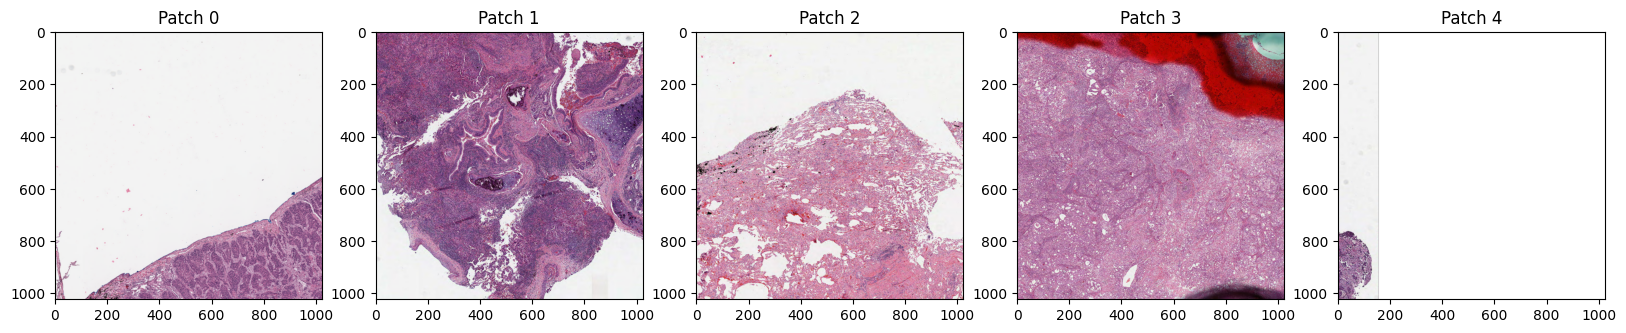

In [10]:
# plot 5 random patches.
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    ax[i].imshow(patches[i])
    ax[i].set_title(f"Patch {i}")


Plot the intensity distribution for each channel of the `patches` array. Compare it against the normalized histogram of the previous image

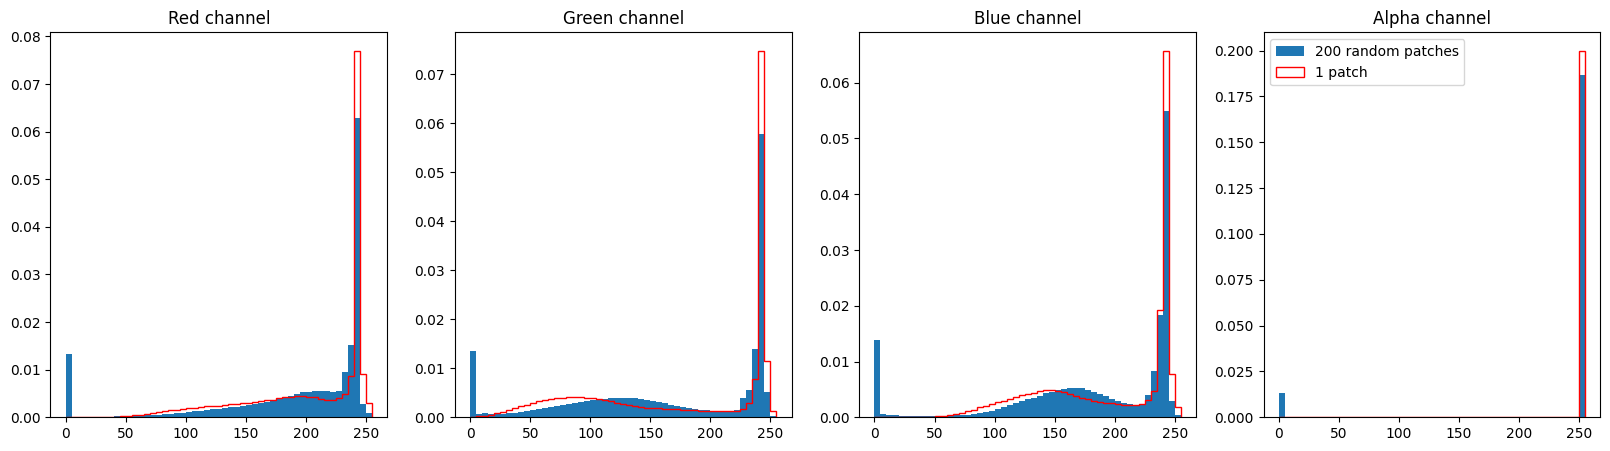

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].set_title("Red channel")
ax[0].hist(patches[..., 0].ravel(), density=True, bins=bins)
ax[0].hist(
    cv_img_unchanged[..., 0].ravel(),
    color="red",
    density=True,
    histtype="step",
    bins=bins,
)
ax[1].set_title("Green channel")
ax[1].hist(patches[..., 1].ravel(), density=True, bins=bins)
ax[1].hist(
    cv_img_unchanged[..., 1].ravel(),
    color="red",
    density=True,
    histtype="step",
    bins=bins,
)
ax[2].set_title("Blue channel")
ax[2].hist(patches[..., 2].ravel(), density=True, bins=bins)
ax[2].hist(
    cv_img_unchanged[..., 2].ravel(),
    color="red",
    density=True,
    histtype="step",
    bins=bins,
)
ax[3].set_title("Alpha channel")
ax[3].hist(patches[..., 3].ravel(), density=True, bins=bins, label="200 random patches")
ax[3].hist(
    cv_img_unchanged[..., 3].ravel(),
    color="red",
    density=True,
    histtype="step",
    bins=bins,
    label="1 patch",
)
ax[3].legend()


<span style="color:green">*Distributions look very similar for one or multiple randomly sampled patches. Therefore, it seems that the alpha channel holds a lot of repeated information*</span>. 

## Defining the splits

The dataset has some samples without masks that are meant to be used for test. The samples that have a patches directory and a mask are for training. Compare the ids of the patches directories and the masks to find which are the test samples.

In [12]:
mask_sample_ids = [mask_path.stem[:-5] for mask_path in masks_paths]
patches_sample_ids = [patch_dir.name for patch_dir in patches_dirs]
test_sample_ids = sorted(list(set(patches_sample_ids).difference(mask_sample_ids)))
train_sample_ids = sorted(list(set(patches_sample_ids).intersection(mask_sample_ids)))

print(f"Number of samples with masks: {len(train_sample_ids)} \n")
print(f"Samples ids without masks:", *test_sample_ids, sep="\n- ")


Number of samples with masks: 33 

Samples ids without masks:
- TCGA-99-8028-01Z-00-DX1.23de89b1-67f8-41fb-980a-010ea190d687
- TCGA-99-8032-01Z-00-DX1.7380b78f-ea25-43e0-ac90-194b5c6b1432
- TCGA-J2-8194-01Z-00-DX1.7700924D-B6AF-46A7-A7D7-B5C17A66C5F7
- TCGA-MP-A4TK-01Z-00-DX1.57494698-D9D9-4C04-AAB2-16616CCFDCC9
- TCGA-NJ-A55R-01Z-00-DX1.2E2B3642-4E1C-47DB-AF7B-988D586C0986


## Error checking at upload

Iterate over the training and test samples directories to make sure they have patches uploaded and that no mask exist for the test samples

### Train split

There are six samples without images inside the patches directories. Aside from that, everything seems fine.

In [13]:
for train_sample_id in train_sample_ids:

    sample_mask_path = masks_dir / f"{train_sample_id}_mask.png"

    sample_patches_dir = patches_dir / train_sample_id
    sample_patches_paths = sorted(sample_patches_dir.iterdir())
    sample_num_patches = len(sample_patches_paths)

    if sample_num_patches == 0:
        print(f"{train_sample_id} do not have patches")

    if not sample_mask_path.exists():
        print(f"{train_sample_id} do not have a mask")


### Test split

Everything seems ordered for the samples in the test split, i.e. all the patch directories contain image and there are no masks.

In [14]:
for test_sample_id in test_sample_ids:

    sample_mask_path = masks_dir / f"{test_sample_id}_mask.png"

    sample_patches_dir = patches_dir / test_sample_id
    sample_patches_paths = sorted(sample_patches_dir.iterdir())
    sample_num_patches = len(sample_patches_paths)

    if sample_num_patches == 0:
        print(f"{test_sample_id} do not have patches")

    if sample_mask_path.exists():
        print(f"{test_sample_id} has a mask")


<a id='the_destination'></a>

## Image reconstruction: how to overlap the masks and patches

### Unusual things

#### Square grid

At first, I believed that the patches should make a squared grid. Nevertheless, taking a look at the samples from the training split, this idea quickly goes away.

In [15]:
for train_sample_id in train_sample_ids:

    sample_patches_dir = patches_dir / train_sample_id
    sample_patches_paths = sorted(sample_patches_dir.iterdir())
    sample_num_patches = len(sample_patches_paths)

    if sample_num_patches > 0:
        if not np.sqrt(sample_num_patches).is_integer():
            print(
                f"{train_sample_id}: Number of patches is not a perfect square (n={sample_num_patches})."
            )


TCGA-35-3615-01Z-00-DX1.585128eb-6652-4b05-9a83-dc8f242904a6: Number of patches is not a perfect square (n=23).
TCGA-44-6144-01Z-00-DX1.604b3c7c-92e8-474a-bae8-e48415ea6196: Number of patches is not a perfect square (n=6).
TCGA-44-7672-01Z-00-DX1.71f4a0c6-a9cc-481c-ace8-c8c314952aa1: Number of patches is not a perfect square (n=11).
TCGA-49-4505-01Z-00-DX1.d49d603e-1f76-43a1-a803-9f2d6a6df715: Number of patches is not a perfect square (n=23).
TCGA-4B-A93V-01Z-00-DX1.C263DC1C-298D-47ED-AAF8-128043828530: Number of patches is not a perfect square (n=26).
TCGA-55-7284-01Z-00-DX1.68b95b9b-1aab-4f03-aad3-1132467b7499: Number of patches is not a perfect square (n=13).
TCGA-55-7815-01Z-00-DX1.288408e6-f6b3-4de4-a1ce-cb2498d9d46d: Number of patches is not a perfect square (n=10).
TCGA-55-7911-01Z-00-DX1.081bc002-06ee-4218-a25f-26c0e6c4b333: Number of patches is not a perfect square (n=10).
TCGA-55-8203-01Z-00-DX1.f530d261-be19-4ff0-98d0-27b789dffb23: Number of patches is not a perfect square (

#### Missing patches

In [16]:
today_str = datetime.now().strftime("%Y%m%d")
results_dir = Path(f"../report/{today_str}/")
results_dir.mkdir(exist_ok=True, parents=True)

report_dict = {
    "sample_id": [],
    "mask_shape": [],
    "reconstructed_image_shape": [],
    "num_patches": [],
    "num_missing_patches": [],
    "missing_patches_idxs": [],
}

pbar = tqdm(train_sample_ids)
for sample_id in pbar:

    pbar.set_description(f"Processing {sample_id}")

    sample_patches_dir = patches_dir / sample_id
    sample_patches_paths = sorted(sample_patches_dir.iterdir())

    if len(sample_patches_paths) > 0:
        sorted_sample_patches_paths, missing_patches_idxs = sort_paths_from_idxs(
            sample_patches_paths
        )
        sorted_sample_patches = read_images_grid(sorted_sample_patches_paths)
        reconstructed_sample_image = np.vstack(
            [np.hstack(row) for row in sorted_sample_patches]
        ).astype(np.float32)

        sample_mask_path = masks_dir / f"{sample_id}_mask.png"
        sample_mask = read_mask(sample_mask_path)

        # Process the reconstructed image.
        reconstructed_sample_image = crop_black_frames_from_image(reconstructed_sample_image)
        reconstructed_sample_image = reconstructed_sample_image / 255.0
        
        # Resize mask to cropped reconstructed image.
        height, width = reconstructed_sample_image.shape[:2]
        resized_sample_mask = cv2.resize(sample_mask, (width, height))
        data_with_mask = plotting.overlay_masks_on_data(
            np.expand_dims(reconstructed_sample_image, axis=0),
            np.expand_dims(resized_sample_mask, axis=-1),
            true_mask_with_contours=False,
        ).clip(0, 1)

        # Save results.
        sample_results_dir = results_dir / sample_id
        sample_results_dir.mkdir(exist_ok=True)

        report_dict["sample_id"].append(sample_id)
        report_dict["num_missing_patches"].append(len(missing_patches_idxs))
        report_dict["missing_patches_idxs"].append(
            ", ".join([str(i) for i in missing_patches_idxs])
        )
        report_dict["mask_shape"].append(sample_mask.shape)
        report_dict["reconstructed_image_shape"].append(
            reconstructed_sample_image.shape
        )
        report_dict["num_patches"].append(len(sample_patches_paths))

        plt.figure(figsize=(20, 20))
        plt.imshow(data_with_mask[0])
        for j, i in missing_patches_idxs:
            y, x = 512 + (1024 * j), 350 + (1024 * i)
            plt.annotate(
                f"$[{j}, {i}]$",
                xy=(x, y),
                color="yellow",
                fontsize=16,
            )
        plt.savefig(
            str(sample_results_dir / "reconstructed_image_with_resize_mask.png"),
            bbox_inches="tight",
        )
        plt.close()

    else:

        sample_mask_path = masks_dir / f"{sample_id}_mask.png"
        sample_mask = read_mask(sample_mask_path)

        report_dict["sample_id"].append(sample_id)
        report_dict["num_missing_patches"].append(None)
        report_dict["missing_patches_idxs"].append(None)
        report_dict["mask_shape"].append(sample_mask.shape)
        report_dict["reconstructed_image_shape"].append(None)
        report_dict["num_patches"].append(0)

report_df = pd.DataFrame(report_dict)
report_df.to_excel(results_dir / "report.xlsx", index=False)


  0%|          | 0/33 [00:00<?, ?it/s]

In [17]:
report_df


,sample_id,mask_shape,reconstructed_image_shape,num_patches,num_missing_patches,missing_patches_idxs
0,TCGA-35-3615-01Z-00-DX1.585128eb-6652-4b05-9a8...,"(1956, 4166)","(3914, 8333, 3)",23,13,"[0, 3], [0, 4], [0, 8], [1, 3], [1, 4], [1, 8]..."
1,TCGA-44-6144-01Z-00-DX1.604b3c7c-92e8-474a-bae...,"(1318, 2637)","(2637, 5275, 3)",6,12,"[0, 2], [0, 3], [0, 4], [0, 5], [1, 1], [1, 2]..."
2,TCGA-44-7672-01Z-00-DX1.71f4a0c6-a9cc-481c-ace...,"(1382, 2727)","(2765, 5456, 3)",11,7,"[0, 1], [0, 2], [0, 5], [1, 2], [2, 2], [2, 3]..."
3,TCGA-49-4505-01Z-00-DX1.d49d603e-1f76-43a1-a80...,"(2462, 3027)","(4926, 6055, 3)",23,7,"[0, 3], [0, 4], [0, 5], [1, 5], [4, 0], [4, 4]..."
4,TCGA-4B-A93V-01Z-00-DX1.C263DC1C-298D-47ED-AAF...,"(2337, 2738)","(4675, 5477, 3)",26,4,"[0, 5], [1, 5], [4, 0], [4, 5]"
5,TCGA-55-7284-01Z-00-DX1.68b95b9b-1aab-4f03-aad...,"(1705, 2577)","(3412, 5119, 3)",13,7,"[0, 0], [0, 1], [0, 2], [3, 0], [3, 2], [3, 3]..."
6,TCGA-55-7815-01Z-00-DX1.288408e6-f6b3-4de4-a1c...,"(1484, 1648)","(2969, 3297, 3)",10,2,"[0, 3], [2, 3]"
7,TCGA-55-7911-01Z-00-DX1.081bc002-06ee-4218-a25...,"(1334, 1708)","(2669, 3417, 3)",10,2,"[1, 3], [2, 3]"
8,TCGA-55-8090-01Z-00-DX1.83f86d5f-7cb9-443a-a81...,"(909, 1109)","(1819, 2047, 3)",4,0,
9,TCGA-55-8094-01Z-00-DX1.8dc29615-e124-4f17-81a...,"(980, 1109)","(1962, 2047, 3)",4,0,


# Quitar TCGA-55-8207-01Z-00-DX1.2dafc442-f927-4b0d-b197-cc8c5f86d0fc